In [1]:
# Extendido de:
# https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b

# **Variational AutoEncoder (VAE)**

<img src="VAE.png" align="center" style="float" width="800">

### **Variational autoencoder**

El autoencoder estándar puede tener un problema debido a que el espacio latente puede ser irregular [1]. Es decir, puntos cercanos en el espacio latente pueden producir salidas muy diferentes, y sin sentido, en el decoder.

Una solución a esto es el Variational Autoencoder. Al igual que el autoencoder se compone de dos redes neuronales, el encoder y el decoder, pero hay varias diferencias:

- El input al decoder se codifica como una **distribución** sobre el espacio latente, en vez de como un único punto. Esta distribución se elige que sea normal (Gaussiana) de tal forma que el encoder da como salida el vector media y la matriz de covarianza. En otras palabras, el encoder toma como entrada un patrón (una imagen por ejemplo), y devuelve un vector media y una matriz de covarianza asociada a ese patrón.

- Para utilizar el decoder, se toma un punto de la distribución dada por el encoder, se aplica el decoder en él, y se calcula el error de reconstrucción.

- Este error se utiliza para calcular el loss del VAE. Since the sampling procedure is a discrete process, so it’s not continuous, we need to apply a reparameterisation trick to make the backpropagation work:

$$
z = E(z) + \epsilon \cdot \sqrt{V(z)}
$$

donde $\epsilon \sim N(0, I)$

### **VAE Loss Function**

El loss del VAE consta de dos términos:

- El **error de reconstrucción**, que se obtiene comparando la entrada al encoder con la salida del decoder.

- El **término de regularización KL**, también llamada "divergencia de Kullback-Leibler" entre la distribución devuelta por el encoder y la distribución normal (distribución Gaussiana) [3]. Este término actúa como un regularizador en el espacio latente, haciendo que las distribuciones devueltas por el encoder sean lo más parecidas posibles a una distribución normal (distribución Gaussiana).

$$
loss = error\_reconstrucción + KL(z, N(0,I))
$$

### **Links de interés**

[1] https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

[2] https://atcold.github.io/pytorch-Deep-Learning/en/week08/08-3/

[3] https://avandekleut.github.io/vae/

In [2]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px

In [3]:
CUDA  = False

#dataset = "MNIST"
dataset = "FashionMNIST"
#dataset = "EMNIST"

In [4]:
data_dir = 'dataset'
if dataset == "MNIST":
    train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
    test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)
elif dataset == "FashionMNIST":
    train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
    test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)
else:
    # EMNIST:
    # https://arxiv.org/pdf/1702.05373.pdf
    # https://pytorch.org/vision/master/generated/torchvision.datasets.EMNIST.html

    split = "balanced"
    aux = [10,11,12,36,37,38] # 10, 11, 12, 36, 37, 38
    
    train_dataset = torchvision.datasets.EMNIST(data_dir, split=split, train=True, download=True)
    inds = [ind for ind,x in enumerate(train_dataset.targets) if x in aux]
    train_dataset.data    = train_dataset.data[inds]
    train_dataset.data    = np.swapaxes(train_dataset.data, 2, 1)
    train_dataset.targets = train_dataset.targets[inds]
    for i,a in enumerate(aux):
        train_dataset.targets[train_dataset.targets == a] = i
    
    test_dataset  = torchvision.datasets.EMNIST(data_dir, split=split, train=False, download=True)
    inds = [ind for ind,x in enumerate(test_dataset.targets) if x in aux]
    test_dataset.data     = test_dataset.data[inds]
    test_dataset.data     = np.swapaxes(test_dataset.data, 2, 1)
    test_dataset.targets  = test_dataset.targets[inds]  
    for i,a in enumerate(aux):
        test_dataset.targets[test_dataset.targets == a] = i

100%|██████████| 26421880/26421880 [00:14<00:00, 1807415.37it/s]


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 56460.62it/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2153843.49it/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16751184.63it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



In [5]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [6]:
train_dataset.targets.shape

torch.Size([60000])

In [7]:
np.unique(train_dataset.targets)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

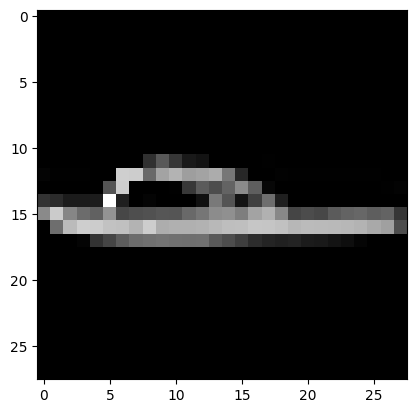

In [8]:
i = 30
plt.imshow(train_dataset.data[i], cmap="gray");

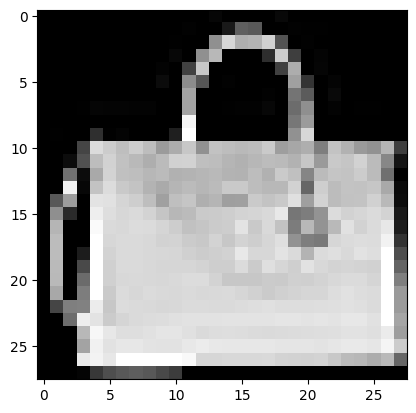

In [9]:
plt.imshow(test_dataset.data[i], cmap="gray");

In [10]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

In [11]:
test_dataset.targets.shape

torch.Size([10000])

In [12]:
np.unique(test_dataset.targets)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

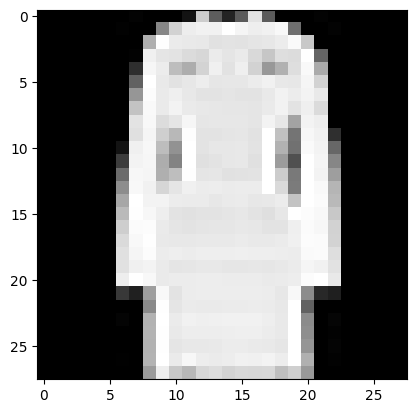

In [13]:
plt.imshow(train_dataset.data[500], cmap="gray");

In [14]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [15]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [16]:
i = 0
for x, _ in train_loader:
    print(x.shape)
    i += 1
    if i==10:
        break

torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])


## 1.Define Encoder and Decoder classes

**Formato de nn.conv2D:** nn.conv2D(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1)

- No incluye parámetro ReLU, eso se especifica dentro del forward, no aquí.
- En __init__ solo se especifican componentes dinámicos, entre ellos el Dropout (para que se pueda activar o desactivar en función de si se está en training o no)

**Visualización intuitiva de estos parámetros (incluyendo dilation):** https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

**La salida de Conv2d, si le llegan imágenes de tamaño INPUT_WIDTH x INPUT_WIDTH, tienen anchura (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html):**

$$\lfloor \frac{INPUT\_WIDTH + 2 \cdot PADDING - DILATION \cdot (KERNEL\_SIZE-1)}{STRIDE} \rfloor$$

In [17]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        
        # Formato de nn.conv2D:
        #    nn.conv2D(in_channels, out_channels, kernel_size, stride, padding)
        # No incluye parámetro ReLU, eso se especifica dentro del forward, no aquí.
        # En __init__ solo se especifican componentes dinámicos, entre ellos el Dropout
        # (para que se pueda activar o desactivar en función de si se está en training o no)

        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        # out_width = (INPUT_WIDTH + 2*PADDING - DILATION*(KERNEL_SIZE-1) - 1)/STRIDE + 1
        # Para imágenes de 28x28, padding=1, kernel_size=3 y stride = 2 (por defecto dilation=1):
        # out_width = (28 + 2*1 - 1*(3-1)) / 2 = 28 / 2 = 14
        
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        # out_width = (14 + 2*1 - 1*(3-1)) / 2 = 14 / 2 = 7

        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (7 + 2*0 - 1*(3-1)) / 2 = 3 (parte entera)
        # imágenes de 3x3, 32 canales. Número total de pixels: 3*3*32

        #self.drop1=nn.Dropout2d(p=0.3)

        # nn.Linear, como conv2D, no incluye parámetro ReLU, eso se especifica
        # dentro del forward.

        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        if CUDA:
            # media de la distribución normal (0):
            self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
            # desviación estándar de la distribución normal (1):
            self.N.scale = self.N.scale.cuda()
        self.kl = 0

    """
    def forward(self, x):
        #print(x.shape)
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    """
    
    def forward(self, x, debug=False):
        if debug:
            print("- Input shape:", x.shape)
        
        x = x.to(device)
        x = F.relu(self.conv1(x))
        if debug:
            print("- conv1 output shape:", x.shape)
        
        x = F.relu(self.batch2(self.conv2(x)))
        if debug:
            print("- conv2 output shape:", x.shape)
        
        x = F.relu(self.conv3(x))
        if debug:
            print("- conv3 output shape:", x.shape)
        
        x = torch.flatten(x, start_dim=1)
        if debug:
            print("- flatten output shape:", x.shape)
        
        x = F.relu(self.linear1(x))
        if debug:
            print("- linear1 output shape:", x.shape)

        mu =  self.linear2(x)
        if debug:
            print("- linear2 (mu) output shape:", mu.shape)

        sigma = torch.exp(self.linear3(x))
        if debug:
            print("- linear3 (sigma) output shape:", sigma.shape)

        z = mu + sigma*self.N.sample(mu.shape)
        if debug:
            print("- total output (z) shape:", z.shape)
        
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [18]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [19]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## 2.Initialize model, optimizer, loss

In [20]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 2

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cpu


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=2, bias=True)
    (linear3): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

In [21]:
vae.encoder(train_dataset.data[:5].reshape(-1,1,28,28).type(torch.FloatTensor), debug=True)

- Input shape: torch.Size([5, 1, 28, 28])
- conv1 output shape: torch.Size([5, 8, 14, 14])
- conv2 output shape: torch.Size([5, 16, 7, 7])
- conv3 output shape: torch.Size([5, 32, 3, 3])
- flatten output shape: torch.Size([5, 288])
- linear1 output shape: torch.Size([5, 128])
- linear2 (mu) output shape: torch.Size([5, 2])
- linear3 (sigma) output shape: torch.Size([5, 2])
- total output (z) shape: torch.Size([5, 2])


tensor([[-0.2899, -0.4561],
        [ 0.4041, -2.1746],
        [-1.7373,  1.2893],
        [ 2.0772,  0.0698],
        [-0.3186, -0.1417]], grad_fn=<AddBackward0>)

## 3.Training

In [22]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [23]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [24]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

In [25]:
num_epochs = 50
for epoch in range(num_epochs):

   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

   plot_ae_outputs(vae.encoder,vae.decoder,n=5)

Output hidden; open in https://colab.research.google.com to view.

## 4.Generate samples

In [26]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            #print("Z:", z)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

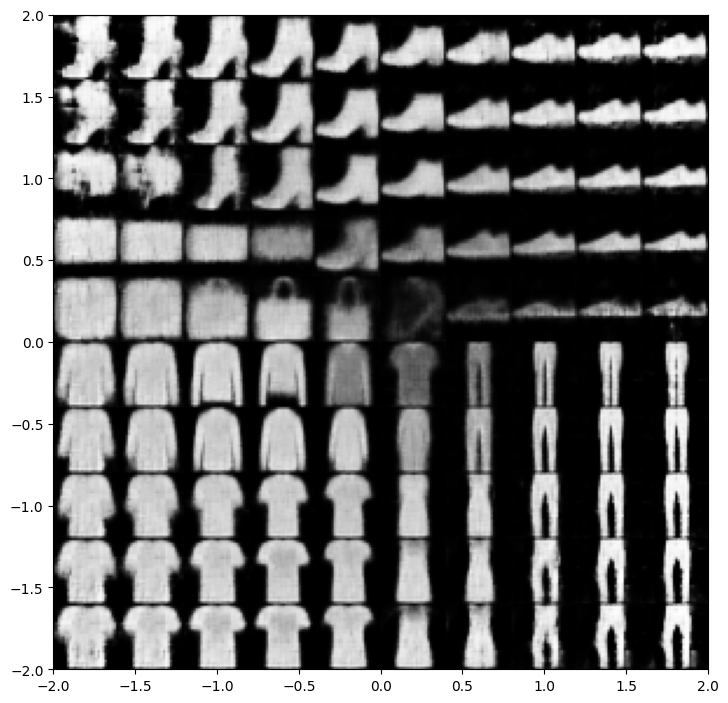

In [27]:
plot_reconstructed(vae.decoder, r0=(-2, 2), r1=(-2, 2))

## 5.Visualize latent space

In [28]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:09<00:00, 1096.95it/s]


In [29]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,label
0,0.133082,0.846910,9
1,-0.861774,-0.229374,2
2,1.261202,-0.960838,1
3,0.941582,-0.258107,1
4,-0.303235,-0.146753,6
...,...,...,...
9995,-0.071477,1.142664,9
9996,0.850362,-0.134989,1
9997,0.159427,-0.033300,8
9998,1.406213,-0.197285,1


In [30]:
from sklearn.manifold import TSNE
import plotly.express as px

In [31]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [32]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

In [33]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()